In [1]:
import seaborn as sn
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import torch
torch.manual_seed(seed_value)

In [2]:
Training_Data = pd.ExcelFile("Training Data.xlsx") #Training Data already pre-scaled to the IBIS Data set
Label_Data = pd.ExcelFile("Labels.xlsx") #Labels
data = Training_Data.parse(Training_Data.sheet_names[1])
label_data = Label_Data.parse(Label_Data.sheet_names[1])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'HYP', 'INDEX MEDU', 'MATCH DEMOS OLD', 'INDEX AGE'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['ATP'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['ROI','MATCH BASC2', 'INDEX ATP', 'INDEX HYP', 'HYP'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

(127, 300)
(127, 1)


In [3]:
twin_data = Training_Data.parse(Training_Data.sheet_names[3])
label_twin_data = Label_Data.parse(Label_Data.sheet_names[3])
twin_data_features = twin_data.loc[:, twin_data.columns]
twin_data_features = twin_data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'HYP', 'INDEX MEDU', 'MATCH DEMOS OLD', 'INDEX AGE'], axis=1)
twin_data_features = twin_data_features.dropna()
twin_data_features = twin_data_features.drop(['ATP'], axis=1)
twin_labels = label_twin_data.loc[:, label_twin_data.columns]
twin_labels = twin_labels.drop(['ROI','MATCH BASC2', 'INDEX ATP', 'INDEX HYP', 'HYP'], axis=1)
twin_labels = twin_labels.dropna()
print(twin_data_features.shape)
print(twin_labels.shape)

#Grab every other row so as to not get both twins
twin_data_features = twin_data_features.iloc[::2, :]
twin_labels = twin_labels.iloc[::2, :]
print(twin_data_features.shape)
print(twin_labels.shape)

(161, 300)
(162, 1)
(81, 300)
(81, 1)


In [4]:
data_1y = [data_features, twin_data_features]
labels_1y = [labels, twin_labels]

data_features = pd.concat(data_1y)
labels = pd.concat(labels_1y)

print(data_features.shape)
print(labels.shape)

(208, 300)
(208, 1)


In [5]:
skf = StratifiedKFold(n_splits=8)
skf.get_n_splits(data_features, labels)
print(skf)

training_indices_X = []
testing_indices_X = []
training_indices_Y = []
testing_indices_Y = []

for train_index, test_index in skf.split(data_features, labels):
  
    X_train, X_test = data_features.iloc[train_index], data_features.iloc[test_index]
    Y_train, Y_test = labels.iloc[train_index], labels.iloc[test_index]
   
    sm = SMOTE(sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2) 
    X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train) #Only smote the training set.
    print(X_train_res.shape)
    training_indices_X.append(X_train_res)
    testing_indices_X.append(X_test)
    training_indices_Y.append(Y_train_res)
    testing_indices_Y.append(Y_test)


StratifiedKFold(n_splits=8, random_state=None, shuffle=False)
(322, 300)
(324, 300)
(324, 300)
(324, 300)
(324, 300)
(324, 300)
(324, 300)
(324, 300)


In [6]:
training_indices_X[0].head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,SEX,Gestational Age,Maternal Education MEDU,Age at MRI 2
0,-0.293787,0.003139,0.025914,0.167209,-0.327508,-0.292465,-0.348738,-0.218615,-0.078855,-0.086240,...,0.334543,0.743217,0.229896,0.115003,0.613862,0.419573,0.0,0.916667,14.0,1.161644
1,-0.134314,0.048638,0.157068,-0.118706,-0.098239,-0.109438,0.014594,-0.336313,0.074765,0.071769,...,0.216634,0.271318,0.347661,0.134042,0.413723,0.255445,1.0,0.750000,9.0,1.024658
2,-0.163454,0.075192,-0.022291,-0.138708,-0.049811,0.057390,-0.165016,-0.404240,-0.087664,-0.077308,...,0.226022,0.419697,0.351481,0.487143,0.186957,0.223046,1.0,0.833333,10.0,0.972603
3,-0.218534,0.169836,0.078778,-0.119622,-0.115461,-0.025809,-0.204149,-0.307287,0.006419,0.017864,...,0.111862,0.116289,0.470573,0.422930,0.165222,0.099071,0.0,0.750000,18.0,1.032877
4,-0.234619,0.065529,0.053342,-0.084426,-0.305915,0.085034,0.092923,-0.273483,0.017809,-0.040153,...,0.050710,0.160398,0.249255,0.312704,0.111889,0.509838,1.0,0.750000,18.0,0.982192


In [7]:
#training_indices_X[0] #8 Folds so 0 -> 7 Data type is a DataFrame currently.
training_fold_X_0 = training_indices_X[0].to_numpy()
training_fold_X_1 = training_indices_X[1].to_numpy()
training_fold_X_2 = training_indices_X[2].to_numpy()
training_fold_X_3 = training_indices_X[3].to_numpy()
training_fold_X_4 = training_indices_X[4].to_numpy()
training_fold_X_5 = training_indices_X[5].to_numpy()
training_fold_X_6 = training_indices_X[6].to_numpy()
training_fold_X_7 = training_indices_X[7].to_numpy()

training_fold_Y_0 = training_indices_Y[0].to_numpy()
training_fold_Y_1 = training_indices_Y[1].to_numpy()
training_fold_Y_2 = training_indices_Y[2].to_numpy()
training_fold_Y_3 = training_indices_Y[3].to_numpy()
training_fold_Y_4 = training_indices_Y[4].to_numpy()
training_fold_Y_5 = training_indices_Y[5].to_numpy()
training_fold_Y_6 = training_indices_Y[6].to_numpy()
training_fold_Y_7 = training_indices_Y[7].to_numpy()

testing_fold_X_0 = testing_indices_X[0].to_numpy()
testing_fold_X_1 = testing_indices_X[1].to_numpy()
testing_fold_X_2 = testing_indices_X[2].to_numpy()
testing_fold_X_3 = testing_indices_X[3].to_numpy()
testing_fold_X_4 = testing_indices_X[4].to_numpy()
testing_fold_X_5 = testing_indices_X[5].to_numpy()
testing_fold_X_6 = testing_indices_X[6].to_numpy()
testing_fold_X_7 = testing_indices_X[7].to_numpy()

testing_fold_Y_0 = testing_indices_Y[0].to_numpy()
testing_fold_Y_1 = testing_indices_Y[1].to_numpy()
testing_fold_Y_2 = testing_indices_Y[2].to_numpy()
testing_fold_Y_3 = testing_indices_Y[3].to_numpy()
testing_fold_Y_4 = testing_indices_Y[4].to_numpy()
testing_fold_Y_5 = testing_indices_Y[5].to_numpy()
testing_fold_Y_6 = testing_indices_Y[6].to_numpy()
testing_fold_Y_7 = testing_indices_Y[7].to_numpy()

In [8]:
print(testing_fold_Y_0.shape)
print(testing_fold_Y_1.shape)
print(testing_fold_Y_2.shape)
print(testing_fold_Y_3.shape)
print(testing_fold_Y_4.shape)
print(testing_fold_Y_5.shape)
print(testing_fold_Y_6.shape)
print(testing_fold_Y_7.shape)

(26, 1)
(26, 1)
(26, 1)
(26, 1)
(26, 1)
(26, 1)
(26, 1)
(26, 1)


In [9]:
#Some hyperparameters
#D_in is input dimension; H is hidden dimension; D_out is output dimension. 
#Best: 0.691927 using {'batch_size': 30, 'dropout': 0.3, 'epochs': 25, 'layer1_size': 130, 'layer2_size': 30}
D_in, H1, H2, D_out = 300, 130, 30, 1
EPOCHS = 25
BATCH_SIZE = 30
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.30

test_size = 29
test_size1 = 28

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data): #used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)

#A dataloader is then used on this dataset class to read the data in batches.
train_data = trainData(torch.FloatTensor(training_fold_X_0), 
                       torch.FloatTensor(training_fold_Y_0))

train_data1 = trainData(torch.FloatTensor(training_fold_X_1), 
                       torch.FloatTensor(training_fold_Y_1))

train_data2 = trainData(torch.FloatTensor(training_fold_X_2), 
                       torch.FloatTensor(training_fold_Y_2))

train_data3 = trainData(torch.FloatTensor(training_fold_X_3), 
                       torch.FloatTensor(training_fold_Y_3))

train_data4 = trainData(torch.FloatTensor(training_fold_X_4), 
                       torch.FloatTensor(training_fold_Y_4))

train_data5 = trainData(torch.FloatTensor(training_fold_X_5), 
                       torch.FloatTensor(training_fold_Y_5))

train_data6 = trainData(torch.FloatTensor(training_fold_X_6), 
                       torch.FloatTensor(training_fold_Y_6))

train_data7 = trainData(torch.FloatTensor(training_fold_X_7), 
                       torch.FloatTensor(training_fold_Y_7))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data): ##used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)
    
#A dataloader is then used on this dataset class to read the data in batches.
test_data = testData(torch.FloatTensor(testing_fold_X_0))
test_data1 = testData(torch.FloatTensor(testing_fold_X_1))
test_data2 = testData(torch.FloatTensor(testing_fold_X_2))
test_data3 = testData(torch.FloatTensor(testing_fold_X_3))
test_data4 = testData(torch.FloatTensor(testing_fold_X_4))
test_data5 = testData(torch.FloatTensor(testing_fold_X_5))
test_data6 = testData(torch.FloatTensor(testing_fold_X_6))
test_data7 = testData(torch.FloatTensor(testing_fold_X_7))

#Initialize DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader1 = DataLoader(dataset=train_data1, batch_size=BATCH_SIZE, shuffle=True)
test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader2 = DataLoader(dataset=train_data2, batch_size=BATCH_SIZE, shuffle=True)
test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader3 = DataLoader(dataset=train_data3, batch_size=BATCH_SIZE, shuffle=True)
test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader4 = DataLoader(dataset=train_data4, batch_size=BATCH_SIZE, shuffle=True)
test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader5 = DataLoader(dataset=train_data5, batch_size=BATCH_SIZE, shuffle=True)
test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader6 = DataLoader(dataset=train_data6, batch_size=BATCH_SIZE, shuffle=True)
test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader7 = DataLoader(dataset=train_data7, batch_size=BATCH_SIZE, shuffle=True)
test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

In [10]:
print(testing_fold_X_0.shape)
print(testing_fold_X_1.shape)
print(testing_fold_X_2.shape)
print(testing_fold_X_3.shape)
print(testing_fold_X_4.shape)
print(testing_fold_X_5.shape)
print(testing_fold_X_6.shape)
print(testing_fold_X_7.shape)

(26, 300)
(26, 300)
(26, 300)
(26, 300)
(26, 300)
(26, 300)
(26, 300)
(26, 300)


In [11]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 298.
        self.layer_1 = nn.Linear(D_in, H1) #298 -> 100
        self.layer_2 = nn.Linear(H1, H2) #100 -> 15
        self.layer_out = nn.Linear(H2, D_out) #15 -> 1
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        #self.batchnorm1 = nn.BatchNorm1d(100)
        #self.batchnorm2 = nn.BatchNorm1d(15)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) #ReLU on the 298?
        #x = self.batchnorm1(x) #Normalize the 100
        x = self.dropout(x) #Dropout 15%
        x = self.relu(self.layer_2(x)) #ReLU on the 100?
        #x = self.batchnorm2(x) #Normalize the 15
        x = self.layer_out(x) #1
        
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#Should use the CPU since I don't have a GPU.

cpu


In [12]:
#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model = binaryClassification()
model.to(device)
print(model)
weights = torch.FloatTensor([5]) #Class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model1's actual architecture can be viewed in the forward function above.
model1 = binaryClassification()
model1.to(device)
print(model1)
weights1 = torch.FloatTensor([5]) #Class weights
criterion1 = nn.BCEWithLogitsLoss(pos_weight=weights1)
optimizer1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model2's actual architecture can be viewed in the forward function above.
model2 = binaryClassification()
model2.to(device)
print(model2)
weights2 = torch.FloatTensor([5]) #Class weights
criterion2 = nn.BCEWithLogitsLoss(pos_weight=weights2)
optimizer2 = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model3's actual architecture can be viewed in the forward function above.
model3 = binaryClassification()
model3.to(device)
print(model3)
weights3 = torch.FloatTensor([5]) #Class weights
criterion3 = nn.BCEWithLogitsLoss(pos_weight=weights3)
optimizer3 = optim.Adam(model3.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model4's actual architecture can be viewed in the forward function above.
model4 = binaryClassification()
model4.to(device)
print(model4)
weights4 = torch.FloatTensor([5]) #Class weights
criterion4 = nn.BCEWithLogitsLoss(pos_weight=weights4)
optimizer4 = optim.Adam(model4.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model5's actual architecture can be viewed in the forward function above.
model5 = binaryClassification()
model5.to(device)
print(model5)
weights5 = torch.FloatTensor([5]) #Class weights
criterion5 = nn.BCEWithLogitsLoss(pos_weight=weights5)
optimizer5 = optim.Adam(model5.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model6's actual architecture can be viewed in the forward function above.
model6 = binaryClassification()
model6.to(device)
print(model6)
weights6 = torch.FloatTensor([5]) #Class weights
criterion6 = nn.BCEWithLogitsLoss(pos_weight=weights6)
optimizer6 = optim.Adam(model6.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model7's actual architecture can be viewed in the forward function above.
model7 = binaryClassification()
model7.to(device)
print(model7)
weights7 = torch.FloatTensor([5]) #Class weights
criterion7 = nn.BCEWithLogitsLoss(pos_weight=weights7)
optimizer7 = optim.Adam(model7.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=300, out_features=130, bias=True)
  (layer_2): Linear(in_features=130, out_features=30, bias=True)
  (layer_out): Linear(in_features=30, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
binaryClassification(
  (layer_1): Linear(in_features=300, out_features=130, bias=True)
  (layer_2): Linear(in_features=130, out_features=30, bias=True)
  (layer_out): Linear(in_features=30, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
binaryClassification(
  (layer_1): Linear(in_features=300, out_features=130, bias=True)
  (layer_2): Linear(in_features=130, out_features=30, bias=True)
  (layer_out): Linear(in_features=30, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
binaryClassification(
  (layer_1): Linear(in_features=300, out_features=130, bias=True)
  (layer_2): Linear(in_features=130, out_features=30, bias=True)
  (laye

In [13]:
#Function to define accuracy. Should look to see if there is a prebuilt that I can use from sci-kit learn or something.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [14]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc = []
train_acc = []
train_loss = []
val_loss = []

model.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc.append(epoch_acc/len(train_loader))
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #Validation metrics here
    model.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_0))
            val_loss.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_0), y_pred_list)
    ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc.append(accuracy*100)
    model.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.84707 | Acc: 45.636
Validation Accuracy |  7.6923076923076925  PPV |  [0.         0.07692308]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.39499 | Acc: 50.091
Validation Accuracy |  7.6923076923076925  PPV |  [0.         0.07692308]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.39533 | Acc: 50.455


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  7.6923076923076925  PPV |  [0.         0.07692308]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.34573 | Acc: 50.000
Validation Accuracy |  7.6923076923076925  PPV |  [0.         0.07692308]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.34928 | Acc: 50.091
Validation Accuracy |  7.6923076923076925  PPV |  [0.         0.07692308]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.34904 | Acc: 49.545
Validation Accuracy |  7.6923076923076925  PPV |  [0.         0.07692308]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.31757 | Acc: 49.727

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation Accuracy |  7.6923076923076925  PPV |  [0.         0.07692308]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.30904 | Acc: 50.182
Validation Accuracy |  7.6923076923076925  PPV |  [0.         0.07692308]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.28813 | Acc: 49.909


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  7.6923076923076925  PPV |  [0.         0.07692308]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.25188 | Acc: 49.818
Validation Accuracy |  7.6923076923076925  PPV |  [0.         0.07692308]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.23487 | Acc: 49.909


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  7.6923076923076925  PPV |  [0.         0.07692308]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.17182 | Acc: 49.545
Validation Accuracy |  7.6923076923076925  PPV |  [0.         0.07692308]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.13229 | Acc: 49.909


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  7.6923076923076925  PPV |  [0.         0.07692308]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.07167 | Acc: 50.818
Validation Accuracy |  7.6923076923076925  PPV |  [0.         0.07692308]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 0.95610 | Acc: 54.636
Validation Accuracy | 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 7.6923076923076925  PPV |  [0.         0.07692308]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 0.89112 | Acc: 59.909
Validation Accuracy |  15.384615384615385  PPV |  [1.         0.08333333]  Recall |  [0.08333333 1.        ]
Training Epoch 017: | Loss: 0.83777 | Acc: 63.545
Validation Accuracy |  30.76923076923077  PPV |  [0.875      0.05555556]  Recall |  [0.29166667 0.5       ]
Training Epoch 018: | Loss: 0.71568 | Acc: 70.909
Validation Accuracy |  34.61538461538461  PPV |  [0.88888889 0.05882353]  Recall |  [0.33333333 0.5       ]
Training Epoch 019: | Loss: 0.63258 | Acc: 78.636
Validation Accuracy |  53.84615384615385  PPV |  [0.875 0.   ]  Recall |  [0.58333333 0.        ]
Training Epoch 020: | Loss: 0.54466 | Acc: 83.273
Validation Accuracy |  53.84615384615385  PPV |  [0.92857143 0.08333333]  Recall |  [0.54166667 0.5       ]
Training Epoch 021: | Loss: 0.47506 | Acc: 83.545
Validation Accuracy |  57.692307692307686  PPV |  [0.88235294 0.        ]  Recall |  [0.625 0.   ]

In [15]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc1 = []
train_acc1 = []
train_loss1 = []
val_loss1 = []

model1.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader1:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer1.zero_grad()
        
        y_pred = model1(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer1.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc1.append(epoch_acc/len(train_loader1))
    train_loss1.append(epoch_loss/len(train_loader1))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader1):.5f} | Acc: {epoch_acc/len(train_loader1):.3f}')
    #Validation metrics here
    model1.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader1:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_1))
            val_loss1.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data1, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_1), y_pred_list)
    ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc1.append(accuracy*100)
    model1.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.68038 | Acc: 48.182
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.37178 | Acc: 49.909
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.36302 | Acc: 50.182
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 004: | Loss: 1.34144 | Acc: 50.091
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.31577 | Acc: 50.091
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 006: | Loss: 1.28820 | Acc: 50.182
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.26709 | Acc: 49.909
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.23609 | Acc: 50.273


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.17787 | Acc: 50.364


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.12881 | Acc: 50.091
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.08834 | Acc: 50.727
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 0.99977 | Acc: 51.273
Validation Accuracy |  15.384615384615385  PPV |  [1.   0.12]  Recall |  [0.04347826 1.        ]
Training Epoch 013: | Loss: 0.94201 | Acc: 55.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  15.384615384615385  PPV |  [1.   0.12]  Recall |  [0.04347826 1.        ]
Training Epoch 014: | Loss: 0.83354 | Acc: 63.455
Validation Accuracy |  46.15384615384615  PPV |  [0.8 0. ]  Recall |  [0.52173913 0.        ]
Training Epoch 015: | Loss: 0.72210 | Acc: 67.636
Validation Accuracy |  53.84615384615385  PPV |  [0.82352941 0.        ]  Recall |  [0.60869565 0.        ]
Training Epoch 016: | Loss: 0.63745 | Acc: 78.727
Validation Accuracy |  46.15384615384615  PPV |  [0.8 0. ]  Recall |  [0.52173913 0.        ]
Training Epoch 017: | Loss: 0.49320 | Acc: 84.182
Validation Accuracy |  57.692307692307686  PPV |  [0.83333333 0.        ]  Recall |  [0.65217391 0.        ]
Training Epoch 018: | Loss: 0.42091 | Acc: 87.273
Validation Accuracy |  69.23076923076923  PPV |  [0.85714286 0.        ]  Recall |  [0.7826087 0.       ]
Training Epoch 019: | Loss: 0.35549 | Acc: 91.545
Validation Accuracy |  69.23076923076923  PPV |  [0.85714286 0.        ]  Recall |  [0.78260

In [16]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc2 = []
train_acc2 = []
train_loss2 = []
val_loss2 = []

model2.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader2:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer2.zero_grad()
        
        y_pred = model2(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer2.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc2.append(epoch_acc/len(train_loader2))
    train_loss2.append(epoch_loss/len(train_loader2))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader2):.5f} | Acc: {epoch_acc/len(train_loader2):.3f}')
    #Validation metrics here
    model2.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_2))
            val_loss2.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_2), y_pred_list)
    ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc2.append(accuracy*100)
    model2.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.78064 | Acc: 49.818
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.34309 | Acc: 50.000
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.37133 | Acc: 50.182


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.32711 | Acc: 50.364
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.31438 | Acc: 50.273
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.29114 | Acc: 50.000
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 007: | Loss: 1.28611 | Acc: 50.545
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.26704 | Acc: 50.091
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 009: | Loss: 1.23089 | Acc: 50.545
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.18458 | Acc: 50.545
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.12688 | Acc: 50.091
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 012: | Loss: 1.11040 | Acc: 50.455
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.04557 | Acc: 53.818
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 0.97028 | Acc: 57.818
Validation Accuracy |  15.384615384615385  PPV |  [0.66666667 0.08695652]  Recall |  [0.08695652 0.66666667]
Training Epoch 015: | Loss: 0.83108 | Acc: 63.545


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  57.692307692307686  PPV |  [0.92857143 0.16666667]  Recall |  [0.56521739 0.66666667]
Training Epoch 016: | Loss: 0.74541 | Acc: 72.727
Validation Accuracy |  30.76923076923077  PPV |  [0.85714286 0.10526316]  Recall |  [0.26086957 0.66666667]
Training Epoch 017: | Loss: 0.73114 | Acc: 75.636
Validation Accuracy |  26.923076923076923  PPV |  [0.83333333 0.1       ]  Recall |  [0.2173913  0.66666667]
Training Epoch 018: | Loss: 0.62631 | Acc: 79.727
Validation Accuracy |  42.30769230769231  PPV |  [0.9   0.125]  Recall |  [0.39130435 0.66666667]
Training Epoch 019: | Loss: 0.51346 | Acc: 81.727
Validation Accuracy |  76.92307692307693  PPV |  [0.9047619 0.2      ]  Recall |  [0.82608696 0.33333333]
Training Epoch 020: | Loss: 0.43735 | Acc: 87.182
Validation Accuracy |  65.38461538461539  PPV |  [0.9375 0.2   ]  Recall |  [0.65217391 0.66666667]
Training Epoch 021: | Loss: 0.41746 | Acc: 86.727
Validation Accuracy |  80.76923076923077  PPV |  [0.90909091 0.25     

In [17]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc3 = []
train_acc3 = []
train_loss3 = []
val_loss3 = []

model3.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader3:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer3.zero_grad()
        
        y_pred = model3(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer3.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc3.append(epoch_acc/len(train_loader3))
    train_loss3.append(epoch_loss/len(train_loader3))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader3):.5f} | Acc: {epoch_acc/len(train_loader3):.3f}')
    #Validation metrics here
    model3.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_3))
            val_loss3.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_3), y_pred_list)
    ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc3.append(accuracy*100)
    model3.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.82604 | Acc: 49.727
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.46658 | Acc: 49.273
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.39794 | Acc: 49.909


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.35755 | Acc: 49.818
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 005: | Loss: 1.33264 | Acc: 49.909
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.30638 | Acc: 50.000
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.29754 | Acc: 50.182
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 008: | Loss: 1.27195 | Acc: 50.182
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.27148 | Acc: 50.364
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.22352 | Acc: 50.091
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 011: | Loss: 1.17885 | Acc: 50.545
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.12297 | Acc: 50.091
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.09158 | Acc: 51.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 0.99150 | Acc: 54.000
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 0.90040 | Acc: 58.000
Validation Accuracy |  34.61538461538461  PPV |  [1.   0.15]  Recall |  [0.26086957 1.        ]
Training Epoch 016: | Loss: 0.81303 | Acc: 64.182
Validation Accuracy |  30.76923076923077  PPV |  [1.         0.14285714]  Recall |  [0.2173913 1.       ]
Training Epoch 017: | Loss: 0.72184 | Acc: 71.727
Validation Accuracy |  46.15384615384615  PPV |  [1.         0.17647059]  Recall |  [0.39130435 1.        ]
Training Epoch 018: | Loss: 0.63997 | Acc: 77.727
Validation Accuracy |  38.46153846153847  PPV |  [0.81818182 0.06666667]  Recall |  [0.39130435 0.33333333]
Training Epoch 019: | Loss: 0.53681 | Acc: 81.364
Validation Accuracy |  42.30769230769231  PPV |  [0.9   0.125]  Recall |  [0.39130435 0.66666667

In [18]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc4 = []
train_acc4 = []
train_loss4 = []
val_loss4 = []

model4.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader4:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer4.zero_grad()
        
        y_pred = model4(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer4.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc4.append(epoch_acc/len(train_loader4))
    train_loss4.append(epoch_loss/len(train_loader4))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader4):.5f} | Acc: {epoch_acc/len(train_loader4):.3f}')
    #Validation metrics here
    model4.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_4))
            val_loss4.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_4), y_pred_list)
    ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc4.append(accuracy*100)
    model4.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.63189 | Acc: 49.727
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 002: | Loss: 1.39074 | Acc: 50.000
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.34072 | Acc: 50.091


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.34034 | Acc: 50.182
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 005: | Loss: 1.31931 | Acc: 49.909
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.28592 | Acc: 50.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.27749 | Acc: 50.091
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.23678 | Acc: 50.000
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 009: | Loss: 1.21044 | Acc: 50.000
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 010: | Loss: 1.15453 | Acc: 50.091
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 011: | Loss: 1.07796 | Acc: 50.455
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 0.99909 | Acc: 49.909


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 0.90559 | Acc: 53.091
Validation Accuracy |  15.384615384615385  PPV |  [1.   0.12]  Recall |  [0.04347826 1.        ]
Training Epoch 014: | Loss: 0.78809 | Acc: 63.182
Validation Accuracy |  19.230769230769234  PPV |  [0.66666667 0.05      ]  Recall |  [0.17391304 0.33333333]
Training Epoch 015: | Loss: 0.68261 | Acc: 72.545
Validation Accuracy |  26.923076923076923  PPV |  [0.7 0. ]  Recall |  [0.30434783 0.        ]
Training Epoch 016: | Loss: 0.59261 | Acc: 79.273
Validation Accuracy |  30.76923076923077  PPV |  [0.72727273 0.        ]  Recall |  [0.34782609 0.        ]
Training Epoch 017: | Loss: 0.54081 | Acc: 82.364
Validation Accuracy |  42.30769230769231  PPV |  [0.78571429 0.        ]  Recall |  [0.47826087 0.        ]
Training Epoch 018: | Loss: 0.43854 | Acc: 87.273
Validation Accuracy |  50.0  PPV |  [0.8125 0.    ]  Recall |  [0.56521739 0.        ]
Tra

In [19]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc5 = []
train_acc5 = []
train_loss5 = []
val_loss5 = []

model5.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader5:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer5.zero_grad()
        
        y_pred = model5(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer5.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc5.append(epoch_acc/len(train_loader5))
    train_loss5.append(epoch_loss/len(train_loader5))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader5):.5f} | Acc: {epoch_acc/len(train_loader5):.3f}')
    #Validation metrics here
    model5.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_5))
            val_loss5.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_5), y_pred_list)
    ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc5.append(accuracy*100)
    model5.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.56557 | Acc: 50.909
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.38191 | Acc: 49.909
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 003: | Loss: 1.37314 | Acc: 50.273
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.32576 | Acc: 50.182
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.33351 | Acc: 50.273
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 006: | Loss: 1.28773 | Acc: 49.727
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.29295 | Acc: 50.273
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.26478 | Acc: 50.182
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.23532 | Acc: 50.091


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.18160 | Acc: 50.182
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.14457 | Acc: 50.182


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.09788 | Acc: 50.818
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.00311 | Acc: 51.727
Validation Accuracy |  15.384615384615385  PPV |  [1.   0.12]  Recall |  [0.04347826 1.        ]
Training Epoch 014: | Loss: 0.91830 | Acc: 59.182
Validation Accuracy |  38.46153846153847  PPV |  [0.88888889 0.11764706]  Recall |  [0.34782609 0.66666667]
Training Epoch 015: | Loss: 0.83754 | Acc: 67.000
Validation Accuracy |  53.84615384615385  PPV |  [0.86666667 0.09090909]  Recall |  [0.56521739 0.33333333]
Training Epoch 016: | Loss: 0.76081 | Acc: 70.364
Validation Accuracy |  53.84615384615385  PPV |  [0.86666667 0.09090909]  Recall |  [0.56521739 0.33333333]
Training Epoch 017: | Loss: 0.62882 | Acc: 79.909
Validation Accuracy |  53.84615384615385  PPV |  [0.86666667 0.09090909]  Recall |  [0.565217

In [20]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc6 = []
train_acc6 = []
train_loss6 = []
val_loss6 = []

model6.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader6:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer6.zero_grad()
        
        y_pred = model6(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer6.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc6.append(epoch_acc/len(train_loader6))
    train_loss6.append(epoch_loss/len(train_loader6))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader6):.5f} | Acc: {epoch_acc/len(train_loader6):.3f}')
    #Validation metrics here
    model6.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_6))
            val_loss6.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_6), y_pred_list)
    ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc6.append(accuracy*100)
    model6.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.77428 | Acc: 50.636
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.39170 | Acc: 50.091
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 003: | Loss: 1.37819 | Acc: 49.727
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.34009 | Acc: 50.091
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 005: | Loss: 1.32710 | Acc: 50.182
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.31920 | Acc: 49.818
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.30949 | Acc: 49.727


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.27708 | Acc: 50.000
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.26013 | Acc: 50.000
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.21790 | Acc: 50.455
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.19575 | Acc: 50.091
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 012: | Loss: 1.14035 | Acc: 49.909
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.08424 | Acc: 50.455
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 014: | Loss: 1.03336 | Acc: 51.818
Validation Accuracy |  19.230769230769234  PPV |  [1.    0.125]  Recall |  [0.08695652 1.        ]
Training Epoch 015: | Loss: 0.89847 | Acc: 55.545
Validation Accuracy |  65.38461538461539  PPV |  [0.88888889 0.125     ]  Recall |  [0.69565217 0.33333333]
Training Epoch 016: | Loss: 0.89031 | Acc: 64.545
Validation Accuracy |  26.923076923076923  PPV |  [0.83333333 0.1       ]  Recall |  [0.2173913  0.66666667]
Training Epoch 017: | Loss: 0.75537 | Acc: 75.364
Validation Accuracy |  46.15384615384615  PPV |  [0.84615385 0.07692308]  Recall |  [0.47826087 0.33333333]
Training Epoch 018: | Loss: 0.67012 | Acc: 75.273
Validation Accuracy |  53.84615384615385  PPV |  [0.86666667 0.09090909]  Recall |  [0.56521739 0.33333333]
Training Epoch 019: | Loss: 0.60795 | Acc: 78.000
Validation Accuracy |  73.07692307692307  PPV |  [0.9        0.16666667]  Recall |  [0.7826087  0.33333333]
Training Epoch 020: | Loss: 0.49437 | Acc: 86.455
Validation

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc7 = []
train_acc7 = []
train_loss7 = []
val_loss7 = []

model7.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader7:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer7.zero_grad()
        
        y_pred = model7(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer7.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc7.append(epoch_acc/len(train_loader7))
    train_loss7.append(epoch_loss/len(train_loader7))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader7):.5f} | Acc: {epoch_acc/len(train_loader7):.3f}')
    #Validation metrics here
    model7.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_7))
            val_loss7.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_7), y_pred_list)
    ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc7.append(accuracy*100)
    model7.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.62991 | Acc: 51.364
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.40201 | Acc: 50.000
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.35978 | Acc: 50.091
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 004: | Loss: 1.35441 | Acc: 49.909
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.32136 | Acc: 50.364
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.30531 | Acc: 50.182
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 007: | Loss: 1.27038 | Acc: 50.000
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.26245 | Acc: 49.909
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.22743 | Acc: 50.455


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.18419 | Acc: 50.545
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.13331 | Acc: 50.545
Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.05239 | Acc: 50.364

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation Accuracy |  11.538461538461538  PPV |  [0.         0.11538462]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.01572 | Acc: 51.727
Validation Accuracy |  15.384615384615385  PPV |  [1.   0.12]  Recall |  [0.04347826 1.        ]
Training Epoch 014: | Loss: 0.92663 | Acc: 55.273
Validation Accuracy |  15.384615384615385  PPV |  [1.   0.12]  Recall |  [0.04347826 1.        ]
Training Epoch 015: | Loss: 0.82992 | Acc: 61.000
Validation Accuracy |  30.76923076923077  PPV |  [1.         0.14285714]  Recall |  [0.2173913 1.       ]
Training Epoch 016: | Loss: 0.70418 | Acc: 70.182
Validation Accuracy |  46.15384615384615  PPV |  [1.         0.17647059]  Recall |  [0.39130435 1.        ]
Training Epoch 017: | Loss: 0.61692 | Acc: 75.545
Validation Accuracy |  65.38461538461539  PPV |  [0.88888889 0.125     ]  Recall |  [0.69565217 0.33333333]
Training Epoch 018: | Loss: 0.53968 | Acc: 83.000
Validation Accuracy |  50.0  PPV |  [0.91666667 0.14285714]  Recall |  [0.47826087 0.66666

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


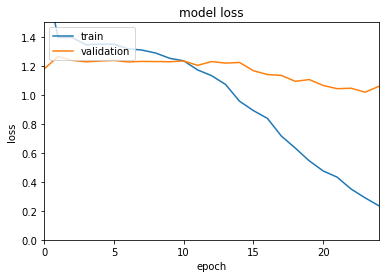

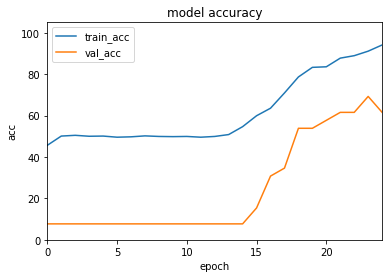

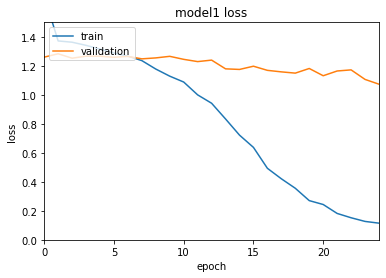

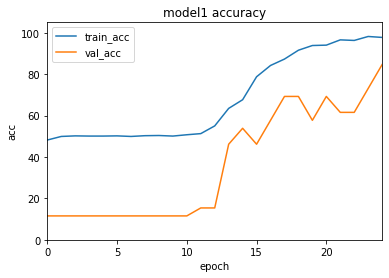

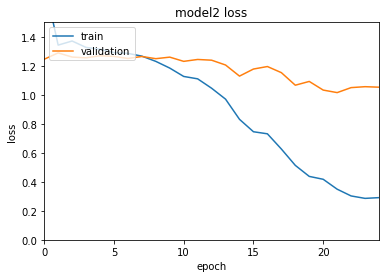

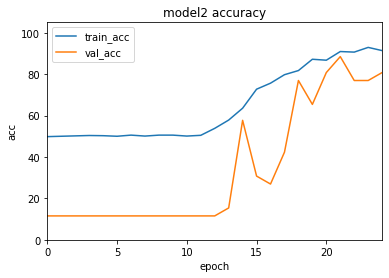

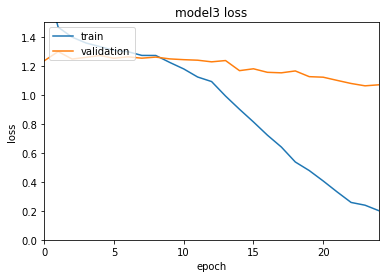

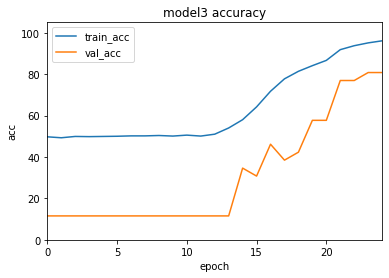

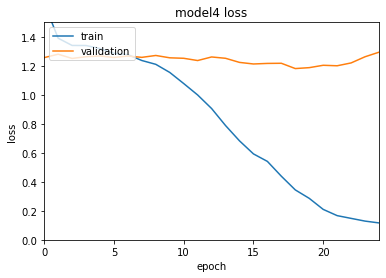

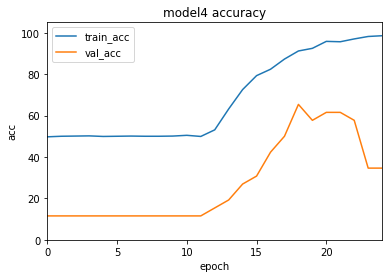

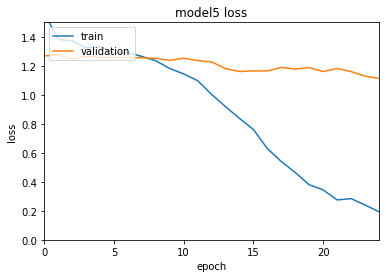

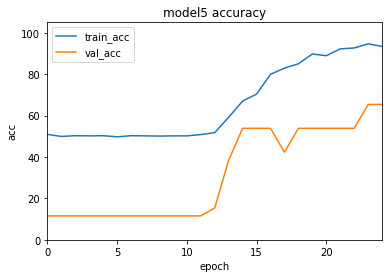

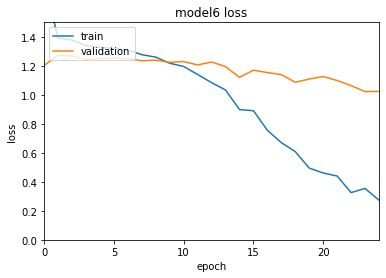

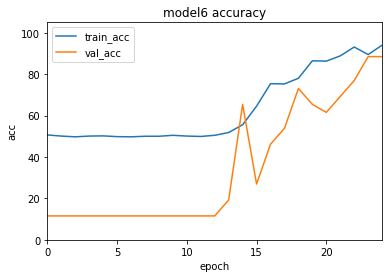

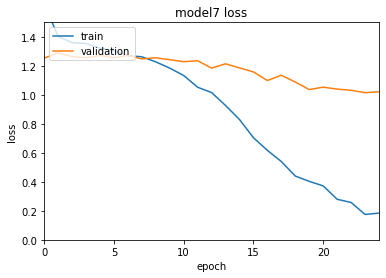

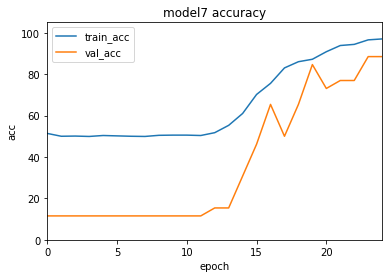

In [22]:
#Plotting loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss1)
plt.plot(val_loss1)
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc1)
plt.plot(val_acc1)
plt.title('model1 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss2)
plt.plot(val_loss2)
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc2)
plt.plot(val_acc2)
plt.title('model2 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss3)
plt.plot(val_loss3)
plt.title('model3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc3)
plt.plot(val_acc3)
plt.title('model3 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss4)
plt.plot(val_loss4)
plt.title('model4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc4)
plt.plot(val_acc4)
plt.title('model4 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss5)
plt.plot(val_loss5)
plt.title('model5 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc5)
plt.plot(val_acc5)
plt.title('model5 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss6)
plt.plot(val_loss6)
plt.title('model6 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc6)
plt.plot(val_acc6)
plt.title('model6 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss7)
plt.plot(val_loss7)
plt.title('model7 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc7)
plt.plot(val_acc7)
plt.title('model7 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

Validation Accuracy |  61.53846153846154  PPV |  [0.9375 0.1   ]  Recall |  [0.625 0.5  ]


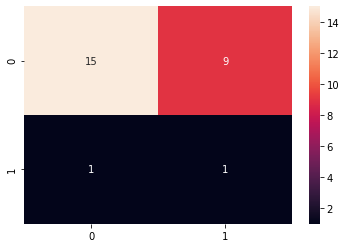

In [23]:
final_prediction = []
final_prediction_true = []

y_pred_list = []
test_loader = DataLoader(dataset=test_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_0, y_pred_list)
ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_0, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_0:
    final_prediction_true.append(y)

Validation Accuracy |  84.61538461538461  PPV |  [0.88 0.  ]  Recall |  [0.95652174 0.        ]


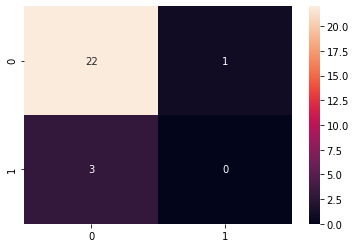

In [24]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data1, batch_size=1)
model1.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model1(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_1, y_pred_list)
ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_1, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_1:
    final_prediction_true.append(y)

Validation Accuracy |  80.76923076923077  PPV |  [0.90909091 0.25      ]  Recall |  [0.86956522 0.33333333]


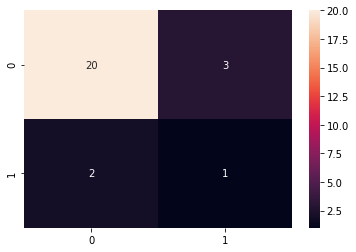

In [25]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data2, batch_size=1)
model2.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model2(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_2, y_pred_list)
ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_2, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_2:
    final_prediction_true.append(y)

Validation Accuracy |  80.76923076923077  PPV |  [0.875 0.   ]  Recall |  [0.91304348 0.        ]


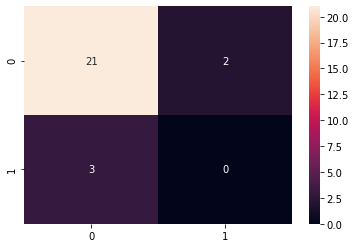

In [26]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data3, batch_size=1)
model3.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model3(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_3, y_pred_list)
ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_3, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_3:
    final_prediction_true.append(y)

Validation Accuracy |  34.61538461538461  PPV |  [0.75 0.  ]  Recall |  [0.39130435 0.        ]


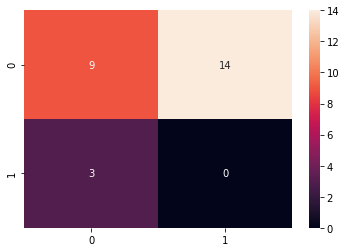

In [27]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data4, batch_size=1)
model4.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model4(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_4, y_pred_list)
ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_4, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_4:
    final_prediction_true.append(y)

Validation Accuracy |  65.38461538461539  PPV |  [0.85 0.  ]  Recall |  [0.73913043 0.        ]


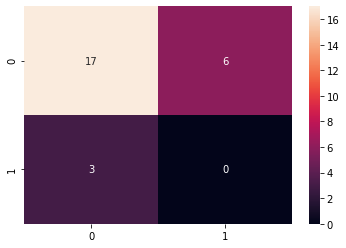

In [28]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data5, batch_size=1)
model5.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model5(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_5, y_pred_list)
ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_5, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_5:
    final_prediction_true.append(y)

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  88.46153846153845  PPV |  [0.88461538 0.        ]  Recall |  [1. 0.]


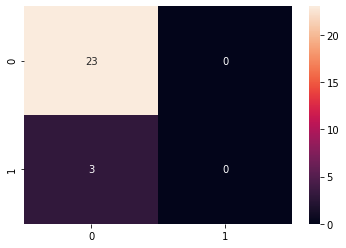

In [29]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data6, batch_size=1)
model6.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model6(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_6, y_pred_list)
ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_6, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_6:
    final_prediction_true.append(y)

Validation Accuracy |  88.46153846153845  PPV |  [0.91666667 0.5       ]  Recall |  [0.95652174 0.33333333]


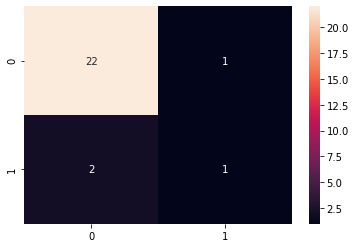

In [30]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data7, batch_size=1)
model7.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model7(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_7, y_pred_list)
ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_7, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_7:
    final_prediction_true.append(y)

In [31]:
prediction_labels = []
true_labels = []

for x in range(0,len(final_prediction_true)):
    true_labels.append(final_prediction_true[x][0])
    prediction_labels.append(final_prediction[x][0][0])

prediction_labels

[1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

[[149  36]
 [ 20   3]]
Positive Predictive Value tp/(tp+fp):  0.07692307692307693
Accuracy Value (tp+tn)/(tp+fp+fn+tn):  0.7307692307692307
Recall Value tp/(tp+fn):  0.13043478260869565


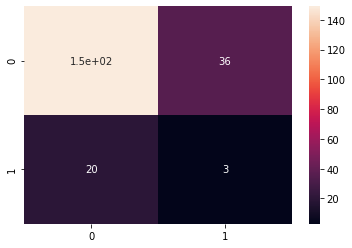

In [32]:
cf_matrix = confusion_matrix(true_labels, prediction_labels)
print(cf_matrix)
sn.heatmap(cf_matrix, annot=True)


accuracy = accuracy_score(true_labels, prediction_labels)
recall = recall_score(true_labels, prediction_labels, average=None)
prec_score = precision_score(true_labels, prediction_labels, average=None)
print('Positive Predictive Value tp/(tp+fp): ',prec_score[1]) 
print('Accuracy Value (tp+tn)/(tp+fp+fn+tn): ',accuracy) 
print('Recall Value tp/(tp+fn): ',recall[1]) 